In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import sys
from tqdm import tqdm

import tensorflow as tf

# <project_root>/ddnet/ddnet.py
sys.path.insert(0, os.path.join(os.path.abspath(''), '..', 'ddnet'))
import ddnet

Using TensorFlow backend.


# Initialize the setting

In [2]:
random.seed(123)

# directory that contains pickle files
undoctored_data_dir = os.path.join(os.path.abspath(''), '..', 'data', 'JHMDB_openpose_tracking_pkl')
doctored_data_dir = os.path.join(os.path.abspath(''), '..', 'data', 'JHMDB_openpose_tracking_doctored_pkl')

# Helper functions

In [3]:
def data_generator(T, C, le, exclude_labels=[]):
    """
    Generate X (list of arrays) and Y (array) from a dict 
    """
    poses = []
    labels = []
    for p, L in zip(T['pose'], T['label']):
        if L not in exclude_labels:
            poses.append(p)
            labels.append(L)
    
    X = poses # list of arrays
    Y = np.zeros(shape=(len(labels), C.clc_num)) # 2D array one-hot encoding of labels
    Y[range(Y.shape[0]), le.transform(labels)] = 1
    return X, Y

In [4]:
# helper functions for plotting
# history is a history object from keras
def plot_accuracy(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def plot_loss(history):
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()  

## Load and Preprocess Data

In [5]:
# Load pickle files
Train_undoctored = pickle.load(open(os.path.join(undoctored_data_dir, "GT_train_1.pkl"), "rb"))
Test_undoctored = pickle.load(open(os.path.join(undoctored_data_dir, "GT_test_1.pkl"), "rb"))

Train_doctored = pickle.load(open(os.path.join(doctored_data_dir, "GT_train_1.pkl"), "rb"))
Test_doctored = pickle.load(open(os.path.join(doctored_data_dir, "GT_test_1.pkl"), "rb"))


from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train_undoctored['label'])
print("Classses: ", len(le.classes_), le.classes_)

Classses:  21 ['brush_hair' 'catch' 'clap' 'climb_stairs' 'golf' 'jump' 'kick_ball'
 'pick' 'pour' 'pullup' 'push' 'run' 'shoot_ball' 'shoot_bow' 'shoot_gun'
 'sit' 'stand' 'swing_baseball' 'throw' 'walk' 'wave']


In [6]:
print(Train_undoctored.keys())
for p, L, filename in zip(Train_undoctored['pose'], Train_undoctored['label'], Train_undoctored['filename']):
    if 'Maddin_winkt' in filename:
        break

print(L, filename)
print(p.dtype)
# print('Nose\n', p[:, 0, :])
print('RElbow\n', p[:, 3, :])
print('RWrist\n', p[:, 4, :])
print('LElbow\n', p[:, 6, :])
print('RWrist\n', p[:, 7, :])

dict_keys(['pose', 'label', 'filename'])
wave wave/Maddin_winkt_wave_h_cm_np1_fr_med_1
float64
RElbow
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
RWrist
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
LElbow
 [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0

### Optionally Combine doctored and undoctored train/test

In [29]:
C = ddnet.DDNetConfig(frame_length=32, num_joints=15, joint_dim=2, num_classes=21, num_filters=32)

X_doctored, Y_doctored = data_generator(Train_doctored,C,le)
X_undoctored, Y_undoctored = data_generator(Train_undoctored,C,le)

# print("Combine doctored and undoctored training sets!")
# X = X_doctored + X_undoctored
# Y = np.concatenate([Y_doctored, Y_undoctored])

X = X_undoctored
Y = Y_undoctored

# X = X_doctored
# Y = Y_doctored

X_test,Y_test = data_generator(Test_undoctored,C,le) #, exclude_labels=['climb_stairs', 'jump', 'kick_ball', 'run', 'sit', 'stand', 'walk'])

print(len(X), X[0].shape, Y.shape)
print(len(X_test), X_test[0].shape, Y_test.shape)

643 (30, 25, 2) (643, 21)
259 (31, 25, 2) (259, 21)


### Cleaning and transforming OpenPose outputs

In [30]:
cleaner = ddnet.OpenPoseDataCleaner(copy=True, filter_joint_idx=ddnet.OP_HAND_PICKED_GOOD_JOINTS)

In [31]:
# filter points that have too many nans
def filter_many_nan_points(X, Y, nan_thres=0.7):
    """
    Input use 0 to indicate nan
    """
    X_filtered = []
    Y_filtered = []
    for p, y in tqdm(zip(X, Y)):
        if cleaner.count_nan(cleaner.make_nan(p)) / p.size <= nan_thres:
            X_filtered.append(p)
            Y_filtered.append(y)
    Y_filtered = np.array(Y_filtered)
    assert len(X_filtered) == Y_filtered.shape[0]
    return X_filtered, Y_filtered

X_filtered, Y_filtered = filter_many_nan_points(X, Y)
X_test_filtered, Y_test_filtered = filter_many_nan_points(X_test, Y_test)
print(len(X_filtered), len(X_test_filtered))

643it [00:00, 16874.84it/s]
259it [00:00, 18301.85it/s]

631 252


In [32]:
# # filter points with no elbow
# def no_elbow(p):
#     RElbow, LElbow = 3, 6
#     # when tracking is ON, openpose outputs non-zero for subsequent frames
# #     return p[0,RElbow, 0] == 0 and p[0,LElbow, 0] == 0
#     return np.all(p[:,RElbow, :]==0) and np.all(p[:, LElbow, :]==0)
    
# def no_hand(p):
#     RWrist, LWrist = 4, 7
# #     return p[0,RWrist, 0] == 0 and p[0,LWrist, 0] == 0
#     return np.all(p[:,RWrist, :]==0) and np.all(p[:, LWrist, :]==0)


# X_noelblow, Y_noelbow = zip(*[(p, y) for p,y in zip(X_filtered, Y_filtered) if (not no_elbow(p)) and (not no_hand(p))])
# Y_noelbow = np.array(Y_noelbow)

# X_test_noelbow, Y_test_noelbow = zip(*[(p, y) for p,y in zip(X_test_filtered, Y_test_filtered) if (not no_elbow(p)) and (not no_hand(p))])
# Y_test_noelbow = np.array(Y_test_noelbow)

# print(len(X_noelblow), len(X_test_noelbow))
# print(Y_noelbow.shape)

In [33]:
# cleaning and data augmentation
X_clean, Y_clean = cleaner.augment_XY(X_filtered, Y_filtered, factor=5)
X_test_clean, Y_test_clean = cleaner.augment_XY(X_test_filtered, Y_test_filtered, factor=5)

print(len(X_clean), X_clean[0].shape, Y_clean.shape)
print(len(X_test_clean), X_test_clean[0].shape, Y_test_clean.shape)

3155 (30, 15, 2) (3155, 21)
1260 (31, 15, 2) (1260, 21)


In [34]:
# commit changes
X_input, Y_input = X_clean, Y_clean
X_test_input, Y_test_input = X_test_clean, Y_test_clean

### DDNet's preprocess and config

In [35]:
# redefine config with new # of joints
C = ddnet.DDNetConfig(frame_length=32, num_joints=X_input[0].shape[1], joint_dim=2, num_classes=21, num_filters=64)

X_0, X_1 = ddnet.preprocess_batch(X_input, C)
X_test_0, X_test_1 = ddnet.preprocess_batch(X_test_input, C)

# Train, Test 

In [36]:
# rescale sample weight to balance classes
def get_sample_weight(Y):
    cls_ids = np.argmax(Y, axis=1)
    assert cls_ids.shape[0] == Y.shape[0]
    cls_histo = np.array([np.count_nonzero(cls_ids==i) for i in range(Y.shape[1])])
    cls_weight = np.max(cls_histo) / cls_histo # balanced
    print(cls_histo)
    print(cls_weight)
    sample_weight = cls_weight[cls_ids]
    assert sample_weight.shape[0] == Y.shape[0]
    return sample_weight

In [37]:
sample_weight = get_sample_weight(Y_input)
print(sample_weight.shape)
print(sample_weight[:10])

[105 170 145 140 150 125 125 120 195 195 150 140 125 185 195 120 120 195
 170 145 140]
[1.85714286 1.14705882 1.34482759 1.39285714 1.3        1.56
 1.56       1.625      1.         1.         1.3        1.39285714
 1.56       1.05405405 1.         1.625      1.625      1.
 1.14705882 1.34482759 1.39285714]
(3155,)
[1.56 1.56 1.56 1.56 1.56 1.56 1.56 1.56 1.56 1.56]


In [38]:
DD_Net = ddnet.create_DDNet(C)
# DD_Net.summary()

### Train and plot loss/accuracy

In [39]:
import keras
from keras import backend as K
from keras.optimizers import *

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)

sess = tf.Session(config=config)
K.set_session(sess)

lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)

history1 = DD_Net.fit([X_0,X_1],Y_input,
                    batch_size=len(Y_input),
                    epochs=800,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test_input),
                    sample_weight=sample_weight
                    )

lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history2 = DD_Net.fit([X_0,X_1],Y_input,
                    batch_size=len(Y_input),
                    epochs=400,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test_input),
                    sample_weight=sample_weight
                    )


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:82:00.0, compute capability: 6.1

Train on 3155 samples, validate on 1260 samples
Epoch 1/800
3155/3155 [==============================] - 6s 2ms/step - loss: 8.6411 - accuracy: 0.0561 - val_loss: 6.7123 - val_accuracy: 0.0238
Epoch 2/800
3155/3155 [==============================] - 0s 106us/step - loss: 8.1662 - accuracy: 0.0887 - val_loss: 6.6698 - val_accuracy: 0.0198
Epoch 3/800
3155/3155 [==============================] - 0s 104us/step - loss: 7.8663 - accuracy: 0.1135 - val_loss: 6.6227 - val_accuracy: 0.0722
Epoch 4/800
3155/3155 [==============================] - 0s 104us/step - loss: 7.6019 - accuracy: 0.1255 - val_loss: 6.5721 - val_accuracy: 0.1111
Epoch 5/800
3155/3155 [==============================] - 0s 102

3155/3155 [==============================] - 0s 103us/step - loss: 2.6411 - accuracy: 0.8358 - val_loss: 4.4970 - val_accuracy: 0.2079
Epoch 55/800
3155/3155 [==============================] - 0s 101us/step - loss: 2.5825 - accuracy: 0.8450 - val_loss: 4.4713 - val_accuracy: 0.2000
Epoch 56/800
3155/3155 [==============================] - 0s 101us/step - loss: 2.5495 - accuracy: 0.8450 - val_loss: 4.4451 - val_accuracy: 0.1921
Epoch 57/800
3155/3155 [==============================] - 0s 101us/step - loss: 2.4852 - accuracy: 0.8469 - val_loss: 4.4200 - val_accuracy: 0.1889
Epoch 58/800
3155/3155 [==============================] - 0s 99us/step - loss: 2.4166 - accuracy: 0.8685 - val_loss: 4.3931 - val_accuracy: 0.1873
Epoch 59/800
3155/3155 [==============================] - 0s 100us/step - loss: 2.3713 - accuracy: 0.8707 - val_loss: 4.3650 - val_accuracy: 0.1968
Epoch 60/800
3155/3155 [==============================] - 0s 101us/step - loss: 2.3340 - accuracy: 0.8631 - val_loss: 4.3338 -

Epoch 110/800
3155/3155 [==============================] - 0s 104us/step - loss: 0.9621 - accuracy: 0.9826 - val_loss: 3.3763 - val_accuracy: 0.3460
Epoch 111/800
3155/3155 [==============================] - 0s 104us/step - loss: 0.9496 - accuracy: 0.9861 - val_loss: 3.3625 - val_accuracy: 0.3516
Epoch 112/800
3155/3155 [==============================] - 0s 102us/step - loss: 0.9295 - accuracy: 0.9851 - val_loss: 3.3468 - val_accuracy: 0.3643
Epoch 113/800
3155/3155 [==============================] - 0s 104us/step - loss: 0.9137 - accuracy: 0.9899 - val_loss: 3.3320 - val_accuracy: 0.3595
Epoch 114/800
3155/3155 [==============================] - 0s 104us/step - loss: 0.8892 - accuracy: 0.9911 - val_loss: 3.3203 - val_accuracy: 0.3595
Epoch 115/800
3155/3155 [==============================] - 0s 104us/step - loss: 0.8780 - accuracy: 0.9930 - val_loss: 3.3096 - val_accuracy: 0.3603
Epoch 116/800
3155/3155 [==============================] - 0s 101us/step - loss: 0.8649 - accuracy: 0.9927

Epoch 165/800
3155/3155 [==============================] - 0s 106us/step - loss: 0.4857 - accuracy: 0.9965 - val_loss: 2.9838 - val_accuracy: 0.4317
Epoch 166/800
3155/3155 [==============================] - 0s 105us/step - loss: 0.4753 - accuracy: 0.9968 - val_loss: 2.9808 - val_accuracy: 0.4357
Epoch 167/800
3155/3155 [==============================] - 0s 106us/step - loss: 0.4687 - accuracy: 0.9971 - val_loss: 2.9781 - val_accuracy: 0.4381
Epoch 168/800
3155/3155 [==============================] - 0s 102us/step - loss: 0.4692 - accuracy: 0.9978 - val_loss: 2.9773 - val_accuracy: 0.4325
Epoch 169/800
3155/3155 [==============================] - 0s 108us/step - loss: 0.4587 - accuracy: 0.9978 - val_loss: 2.9768 - val_accuracy: 0.4294
Epoch 170/800
3155/3155 [==============================] - 0s 107us/step - loss: 0.4619 - accuracy: 0.9956 - val_loss: 2.9758 - val_accuracy: 0.4278
Epoch 171/800
3155/3155 [==============================] - 0s 107us/step - loss: 0.4510 - accuracy: 0.9962

Epoch 220/800
3155/3155 [==============================] - 0s 106us/step - loss: 0.3098 - accuracy: 0.9981 - val_loss: 2.8495 - val_accuracy: 0.4968
Epoch 221/800
3155/3155 [==============================] - 0s 109us/step - loss: 0.3084 - accuracy: 0.9990 - val_loss: 2.8475 - val_accuracy: 0.4937
Epoch 222/800
3155/3155 [==============================] - 0s 109us/step - loss: 0.3046 - accuracy: 0.9990 - val_loss: 2.8450 - val_accuracy: 0.4881
Epoch 223/800
3155/3155 [==============================] - 0s 107us/step - loss: 0.3044 - accuracy: 0.9990 - val_loss: 2.8421 - val_accuracy: 0.4833
Epoch 224/800
3155/3155 [==============================] - 0s 103us/step - loss: 0.3054 - accuracy: 0.9987 - val_loss: 2.8400 - val_accuracy: 0.4865
Epoch 225/800
3155/3155 [==============================] - 0s 103us/step - loss: 0.3114 - accuracy: 0.9978 - val_loss: 2.8376 - val_accuracy: 0.4976
Epoch 226/800
3155/3155 [==============================] - 0s 103us/step - loss: 0.3010 - accuracy: 0.9997

Epoch 275/800
3155/3155 [==============================] - 0s 102us/step - loss: 0.2408 - accuracy: 1.0000 - val_loss: 2.7198 - val_accuracy: 0.5278
Epoch 276/800
3155/3155 [==============================] - 0s 104us/step - loss: 0.2476 - accuracy: 0.9987 - val_loss: 2.7166 - val_accuracy: 0.5325
Epoch 277/800
3155/3155 [==============================] - 0s 103us/step - loss: 0.2484 - accuracy: 0.9981 - val_loss: 2.7195 - val_accuracy: 0.5278
Epoch 278/800
3155/3155 [==============================] - 0s 103us/step - loss: 0.2437 - accuracy: 0.9994 - val_loss: 2.7249 - val_accuracy: 0.5222
Epoch 279/800
3155/3155 [==============================] - 0s 104us/step - loss: 0.2402 - accuracy: 0.9997 - val_loss: 2.7270 - val_accuracy: 0.5206
Epoch 280/800
3155/3155 [==============================] - 0s 104us/step - loss: 0.2440 - accuracy: 0.9994 - val_loss: 2.7250 - val_accuracy: 0.5167
Epoch 281/800
3155/3155 [==============================] - 0s 105us/step - loss: 0.2391 - accuracy: 0.9994

Epoch 330/800
3155/3155 [==============================] - 0s 104us/step - loss: 0.2247 - accuracy: 0.9997 - val_loss: 2.4852 - val_accuracy: 0.5873
Epoch 331/800
3155/3155 [==============================] - 0s 104us/step - loss: 0.2248 - accuracy: 0.9990 - val_loss: 2.4804 - val_accuracy: 0.5865
Epoch 332/800
3155/3155 [==============================] - 0s 104us/step - loss: 0.2238 - accuracy: 1.0000 - val_loss: 2.4753 - val_accuracy: 0.5873
Epoch 333/800
3155/3155 [==============================] - 0s 103us/step - loss: 0.2211 - accuracy: 0.9997 - val_loss: 2.4698 - val_accuracy: 0.5960
Epoch 334/800
3155/3155 [==============================] - 0s 106us/step - loss: 0.2226 - accuracy: 1.0000 - val_loss: 2.4640 - val_accuracy: 0.5921
Epoch 335/800
3155/3155 [==============================] - 0s 105us/step - loss: 0.2237 - accuracy: 0.9997 - val_loss: 2.4582 - val_accuracy: 0.5921
Epoch 336/800
3155/3155 [==============================] - 0s 105us/step - loss: 0.2205 - accuracy: 0.9997

Epoch 385/800
3155/3155 [==============================] - 0s 102us/step - loss: 0.2192 - accuracy: 0.9997 - val_loss: 2.1623 - val_accuracy: 0.5905
Epoch 386/800
3155/3155 [==============================] - 0s 102us/step - loss: 0.2208 - accuracy: 1.0000 - val_loss: 2.1566 - val_accuracy: 0.5921
Epoch 387/800
3155/3155 [==============================] - 0s 103us/step - loss: 0.2204 - accuracy: 0.9994 - val_loss: 2.1509 - val_accuracy: 0.5921
Epoch 388/800
3155/3155 [==============================] - 0s 102us/step - loss: 0.2199 - accuracy: 0.9997 - val_loss: 2.1453 - val_accuracy: 0.5921
Epoch 389/800
3155/3155 [==============================] - 0s 102us/step - loss: 0.2189 - accuracy: 1.0000 - val_loss: 2.1396 - val_accuracy: 0.5929
Epoch 390/800
3155/3155 [==============================] - 0s 103us/step - loss: 0.2196 - accuracy: 0.9997 - val_loss: 2.1340 - val_accuracy: 0.5921
Epoch 391/800
3155/3155 [==============================] - 0s 106us/step - loss: 0.2213 - accuracy: 0.9997

Epoch 440/800
3155/3155 [==============================] - 0s 109us/step - loss: 0.2211 - accuracy: 1.0000 - val_loss: 1.8989 - val_accuracy: 0.5881
Epoch 441/800
3155/3155 [==============================] - 0s 106us/step - loss: 0.2196 - accuracy: 0.9997 - val_loss: 1.8953 - val_accuracy: 0.5873
Epoch 442/800
3155/3155 [==============================] - 0s 106us/step - loss: 0.2219 - accuracy: 0.9997 - val_loss: 1.8916 - val_accuracy: 0.5865
Epoch 443/800
3155/3155 [==============================] - 0s 109us/step - loss: 0.2215 - accuracy: 0.9997 - val_loss: 1.8881 - val_accuracy: 0.5865
Epoch 444/800
3155/3155 [==============================] - 0s 109us/step - loss: 0.2200 - accuracy: 0.9997 - val_loss: 1.8846 - val_accuracy: 0.5873
Epoch 445/800
3155/3155 [==============================] - 0s 108us/step - loss: 0.2181 - accuracy: 1.0000 - val_loss: 1.8811 - val_accuracy: 0.5873
Epoch 446/800
3155/3155 [==============================] - 0s 103us/step - loss: 0.2183 - accuracy: 0.9997

Epoch 495/800
3155/3155 [==============================] - 0s 104us/step - loss: 0.2211 - accuracy: 0.9997 - val_loss: 1.7618 - val_accuracy: 0.5643
Epoch 496/800
3155/3155 [==============================] - 0s 103us/step - loss: 0.2211 - accuracy: 0.9997 - val_loss: 1.7603 - val_accuracy: 0.5643
Epoch 497/800
3155/3155 [==============================] - 0s 105us/step - loss: 0.2203 - accuracy: 0.9997 - val_loss: 1.7590 - val_accuracy: 0.5643
Epoch 498/800
3155/3155 [==============================] - 0s 105us/step - loss: 0.2178 - accuracy: 0.9997 - val_loss: 1.7576 - val_accuracy: 0.5643
Epoch 499/800
3155/3155 [==============================] - 0s 106us/step - loss: 0.2188 - accuracy: 1.0000 - val_loss: 1.7564 - val_accuracy: 0.5643
Epoch 500/800
3155/3155 [==============================] - 0s 105us/step - loss: 0.2186 - accuracy: 0.9990 - val_loss: 1.7552 - val_accuracy: 0.5635
Epoch 501/800
3155/3155 [==============================] - 0s 105us/step - loss: 0.2188 - accuracy: 0.9997

Epoch 550/800
3155/3155 [==============================] - 0s 105us/step - loss: 0.2186 - accuracy: 0.9994 - val_loss: 1.7295 - val_accuracy: 0.5603
Epoch 551/800
3155/3155 [==============================] - 0s 106us/step - loss: 0.2183 - accuracy: 1.0000 - val_loss: 1.7296 - val_accuracy: 0.5603
Epoch 552/800
3155/3155 [==============================] - 0s 105us/step - loss: 0.2205 - accuracy: 0.9997 - val_loss: 1.7297 - val_accuracy: 0.5603
Epoch 553/800
3155/3155 [==============================] - 0s 106us/step - loss: 0.2196 - accuracy: 0.9997 - val_loss: 1.7299 - val_accuracy: 0.5603
Epoch 554/800
3155/3155 [==============================] - 0s 104us/step - loss: 0.2202 - accuracy: 0.9990 - val_loss: 1.7301 - val_accuracy: 0.5603
Epoch 555/800
3155/3155 [==============================] - 0s 104us/step - loss: 0.2178 - accuracy: 0.9997 - val_loss: 1.7304 - val_accuracy: 0.5603
Epoch 556/800
3155/3155 [==============================] - 0s 105us/step - loss: 0.2197 - accuracy: 0.9994

Epoch 605/800
3155/3155 [==============================] - 0s 105us/step - loss: 0.2230 - accuracy: 0.9997 - val_loss: 1.7533 - val_accuracy: 0.5595
Epoch 606/800
3155/3155 [==============================] - 0s 102us/step - loss: 0.2180 - accuracy: 1.0000 - val_loss: 1.7539 - val_accuracy: 0.5595
Epoch 607/800
3155/3155 [==============================] - 0s 102us/step - loss: 0.2202 - accuracy: 1.0000 - val_loss: 1.7545 - val_accuracy: 0.5587
Epoch 608/800
3155/3155 [==============================] - 0s 102us/step - loss: 0.2173 - accuracy: 1.0000 - val_loss: 1.7552 - val_accuracy: 0.5587
Epoch 609/800
3155/3155 [==============================] - 0s 104us/step - loss: 0.2229 - accuracy: 1.0000 - val_loss: 1.7559 - val_accuracy: 0.5587
Epoch 610/800
3155/3155 [==============================] - 0s 103us/step - loss: 0.2194 - accuracy: 0.9997 - val_loss: 1.7566 - val_accuracy: 0.5587
Epoch 611/800
3155/3155 [==============================] - 0s 103us/step - loss: 0.2174 - accuracy: 1.0000

Epoch 660/800
3155/3155 [==============================] - 0s 104us/step - loss: 0.2186 - accuracy: 0.9997 - val_loss: 1.7939 - val_accuracy: 0.5579
Epoch 661/800
3155/3155 [==============================] - 0s 106us/step - loss: 0.2226 - accuracy: 0.9997 - val_loss: 1.7946 - val_accuracy: 0.5579
Epoch 662/800
3155/3155 [==============================] - 0s 105us/step - loss: 0.2185 - accuracy: 0.9994 - val_loss: 1.7952 - val_accuracy: 0.5579
Epoch 663/800
3155/3155 [==============================] - 0s 106us/step - loss: 0.2185 - accuracy: 1.0000 - val_loss: 1.7958 - val_accuracy: 0.5579
Epoch 664/800
3155/3155 [==============================] - 0s 104us/step - loss: 0.2196 - accuracy: 0.9997 - val_loss: 1.7964 - val_accuracy: 0.5579
Epoch 665/800
3155/3155 [==============================] - 0s 105us/step - loss: 0.2198 - accuracy: 1.0000 - val_loss: 1.7969 - val_accuracy: 0.5579
Epoch 666/800
3155/3155 [==============================] - 0s 105us/step - loss: 0.2186 - accuracy: 0.9990

Epoch 715/800
3155/3155 [==============================] - 0s 103us/step - loss: 0.2185 - accuracy: 0.9997 - val_loss: 1.8285 - val_accuracy: 0.5579
Epoch 716/800
3155/3155 [==============================] - 0s 105us/step - loss: 0.2193 - accuracy: 0.9994 - val_loss: 1.8291 - val_accuracy: 0.5579
Epoch 717/800
3155/3155 [==============================] - 0s 105us/step - loss: 0.2158 - accuracy: 1.0000 - val_loss: 1.8297 - val_accuracy: 0.5579
Epoch 718/800
3155/3155 [==============================] - 0s 103us/step - loss: 0.2167 - accuracy: 0.9997 - val_loss: 1.8304 - val_accuracy: 0.5579
Epoch 719/800
3155/3155 [==============================] - 0s 104us/step - loss: 0.2208 - accuracy: 0.9994 - val_loss: 1.8310 - val_accuracy: 0.5579
Epoch 720/800
3155/3155 [==============================] - 0s 105us/step - loss: 0.2170 - accuracy: 0.9994 - val_loss: 1.8316 - val_accuracy: 0.5579
Epoch 721/800
3155/3155 [==============================] - 0s 104us/step - loss: 0.2164 - accuracy: 0.9997

Epoch 770/800
3155/3155 [==============================] - 0s 106us/step - loss: 0.2164 - accuracy: 0.9997 - val_loss: 1.8504 - val_accuracy: 0.5571
Epoch 771/800
3155/3155 [==============================] - 0s 108us/step - loss: 0.2164 - accuracy: 1.0000 - val_loss: 1.8505 - val_accuracy: 0.5563
Epoch 772/800
3155/3155 [==============================] - 0s 102us/step - loss: 0.2188 - accuracy: 1.0000 - val_loss: 1.8505 - val_accuracy: 0.5563
Epoch 773/800
3155/3155 [==============================] - 0s 103us/step - loss: 0.2146 - accuracy: 0.9997 - val_loss: 1.8507 - val_accuracy: 0.5563
Epoch 774/800
3155/3155 [==============================] - 0s 104us/step - loss: 0.2181 - accuracy: 1.0000 - val_loss: 1.8508 - val_accuracy: 0.5563
Epoch 775/800
3155/3155 [==============================] - 0s 104us/step - loss: 0.2186 - accuracy: 1.0000 - val_loss: 1.8511 - val_accuracy: 0.5563
Epoch 776/800
3155/3155 [==============================] - 0s 105us/step - loss: 0.2174 - accuracy: 0.9997

Epoch 25/400
3155/3155 [==============================] - 0s 102us/step - loss: 0.2171 - accuracy: 0.9997 - val_loss: 1.8517 - val_accuracy: 0.5524
Epoch 26/400
3155/3155 [==============================] - 0s 103us/step - loss: 0.2200 - accuracy: 1.0000 - val_loss: 1.8511 - val_accuracy: 0.5532
Epoch 27/400
3155/3155 [==============================] - 0s 104us/step - loss: 0.2198 - accuracy: 0.9994 - val_loss: 1.8505 - val_accuracy: 0.5571
Epoch 28/400
3155/3155 [==============================] - 0s 107us/step - loss: 0.2126 - accuracy: 1.0000 - val_loss: 1.8506 - val_accuracy: 0.5563
Epoch 29/400
3155/3155 [==============================] - 0s 106us/step - loss: 0.2182 - accuracy: 0.9997 - val_loss: 1.8505 - val_accuracy: 0.5563
Epoch 30/400
3155/3155 [==============================] - 0s 104us/step - loss: 0.2153 - accuracy: 0.9994 - val_loss: 1.8502 - val_accuracy: 0.5563
Epoch 31/400
3155/3155 [==============================] - 0s 108us/step - loss: 0.2153 - accuracy: 1.0000 - val_

Epoch 81/400
3155/3155 [==============================] - 0s 105us/step - loss: 0.2116 - accuracy: 1.0000 - val_loss: 1.8664 - val_accuracy: 0.5571
Epoch 82/400
3155/3155 [==============================] - 0s 104us/step - loss: 0.2125 - accuracy: 1.0000 - val_loss: 1.8669 - val_accuracy: 0.5579
Epoch 83/400
3155/3155 [==============================] - 0s 103us/step - loss: 0.2125 - accuracy: 0.9997 - val_loss: 1.8675 - val_accuracy: 0.5579
Epoch 84/400
3155/3155 [==============================] - 0s 104us/step - loss: 0.2122 - accuracy: 0.9997 - val_loss: 1.8680 - val_accuracy: 0.5579
Epoch 85/400
3155/3155 [==============================] - 0s 106us/step - loss: 0.2173 - accuracy: 1.0000 - val_loss: 1.8682 - val_accuracy: 0.5579
Epoch 86/400
3155/3155 [==============================] - 0s 103us/step - loss: 0.2112 - accuracy: 0.9997 - val_loss: 1.8686 - val_accuracy: 0.5579
Epoch 87/400
3155/3155 [==============================] - 0s 103us/step - loss: 0.2130 - accuracy: 1.0000 - val_

Epoch 137/400
3155/3155 [==============================] - 0s 102us/step - loss: 0.2145 - accuracy: 1.0000 - val_loss: 1.8832 - val_accuracy: 0.5579
Epoch 138/400
3155/3155 [==============================] - 0s 103us/step - loss: 0.2112 - accuracy: 0.9997 - val_loss: 1.8830 - val_accuracy: 0.5579
Epoch 139/400
3155/3155 [==============================] - 0s 103us/step - loss: 0.2114 - accuracy: 1.0000 - val_loss: 1.8829 - val_accuracy: 0.5579
Epoch 140/400
3155/3155 [==============================] - 0s 104us/step - loss: 0.2148 - accuracy: 0.9994 - val_loss: 1.8827 - val_accuracy: 0.5579
Epoch 141/400
3155/3155 [==============================] - 0s 104us/step - loss: 0.2111 - accuracy: 0.9994 - val_loss: 1.8825 - val_accuracy: 0.5587
Epoch 142/400
3155/3155 [==============================] - 0s 101us/step - loss: 0.2136 - accuracy: 0.9990 - val_loss: 1.8824 - val_accuracy: 0.5587
Epoch 143/400
3155/3155 [==============================] - 0s 106us/step - loss: 0.2106 - accuracy: 1.0000

Epoch 192/400
3155/3155 [==============================] - 0s 104us/step - loss: 0.2137 - accuracy: 0.9994 - val_loss: 1.8848 - val_accuracy: 0.5643
Epoch 193/400
3155/3155 [==============================] - 0s 106us/step - loss: 0.2115 - accuracy: 1.0000 - val_loss: 1.8853 - val_accuracy: 0.5643
Epoch 194/400
3155/3155 [==============================] - 0s 105us/step - loss: 0.2116 - accuracy: 1.0000 - val_loss: 1.8858 - val_accuracy: 0.5643
Epoch 195/400
3155/3155 [==============================] - 0s 109us/step - loss: 0.2134 - accuracy: 1.0000 - val_loss: 1.8862 - val_accuracy: 0.5643
Epoch 196/400
3155/3155 [==============================] - 0s 114us/step - loss: 0.2173 - accuracy: 0.9987 - val_loss: 1.8865 - val_accuracy: 0.5643
Epoch 197/400
3155/3155 [==============================] - 0s 108us/step - loss: 0.2123 - accuracy: 1.0000 - val_loss: 1.8868 - val_accuracy: 0.5643
Epoch 198/400
3155/3155 [==============================] - 0s 104us/step - loss: 0.2120 - accuracy: 1.0000

Epoch 247/400
3155/3155 [==============================] - 0s 104us/step - loss: 0.2138 - accuracy: 1.0000 - val_loss: 1.8916 - val_accuracy: 0.5635
Epoch 248/400
3155/3155 [==============================] - 0s 104us/step - loss: 0.2102 - accuracy: 0.9990 - val_loss: 1.8916 - val_accuracy: 0.5635
Epoch 249/400
3155/3155 [==============================] - 0s 104us/step - loss: 0.2116 - accuracy: 1.0000 - val_loss: 1.8917 - val_accuracy: 0.5635
Epoch 250/400
3155/3155 [==============================] - 0s 105us/step - loss: 0.2111 - accuracy: 0.9997 - val_loss: 1.8917 - val_accuracy: 0.5635
Epoch 251/400
3155/3155 [==============================] - 0s 113us/step - loss: 0.2127 - accuracy: 0.9990 - val_loss: 1.8921 - val_accuracy: 0.5635
Epoch 252/400
3155/3155 [==============================] - 0s 107us/step - loss: 0.2113 - accuracy: 0.9994 - val_loss: 1.8925 - val_accuracy: 0.5635
Epoch 253/400
3155/3155 [==============================] - 0s 106us/step - loss: 0.2118 - accuracy: 1.0000

Epoch 302/400
3155/3155 [==============================] - 0s 103us/step - loss: 0.2112 - accuracy: 0.9994 - val_loss: 1.8932 - val_accuracy: 0.5643
Epoch 303/400
3155/3155 [==============================] - 0s 104us/step - loss: 0.2127 - accuracy: 1.0000 - val_loss: 1.8934 - val_accuracy: 0.5643
Epoch 304/400
3155/3155 [==============================] - 0s 105us/step - loss: 0.2100 - accuracy: 0.9990 - val_loss: 1.8938 - val_accuracy: 0.5643
Epoch 305/400
3155/3155 [==============================] - 0s 103us/step - loss: 0.2095 - accuracy: 0.9994 - val_loss: 1.8941 - val_accuracy: 0.5643
Epoch 306/400
3155/3155 [==============================] - 0s 103us/step - loss: 0.2135 - accuracy: 0.9990 - val_loss: 1.8946 - val_accuracy: 0.5643
Epoch 307/400
3155/3155 [==============================] - 0s 105us/step - loss: 0.2109 - accuracy: 1.0000 - val_loss: 1.8950 - val_accuracy: 0.5643
Epoch 308/400
3155/3155 [==============================] - 0s 107us/step - loss: 0.2065 - accuracy: 1.0000

Epoch 357/400
3155/3155 [==============================] - 0s 103us/step - loss: 0.2117 - accuracy: 0.9990 - val_loss: 1.8937 - val_accuracy: 0.5627
Epoch 358/400
3155/3155 [==============================] - 0s 103us/step - loss: 0.2130 - accuracy: 0.9994 - val_loss: 1.8933 - val_accuracy: 0.5627
Epoch 359/400
3155/3155 [==============================] - 0s 105us/step - loss: 0.2128 - accuracy: 0.9997 - val_loss: 1.8931 - val_accuracy: 0.5627
Epoch 360/400
3155/3155 [==============================] - 0s 105us/step - loss: 0.2138 - accuracy: 0.9997 - val_loss: 1.8930 - val_accuracy: 0.5627
Epoch 361/400
3155/3155 [==============================] - 0s 104us/step - loss: 0.2108 - accuracy: 0.9997 - val_loss: 1.8928 - val_accuracy: 0.5627
Epoch 362/400
3155/3155 [==============================] - 0s 103us/step - loss: 0.2127 - accuracy: 0.9997 - val_loss: 1.8928 - val_accuracy: 0.5619
Epoch 363/400
3155/3155 [==============================] - 0s 102us/step - loss: 0.2082 - accuracy: 0.9997

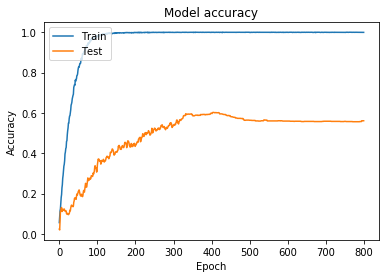

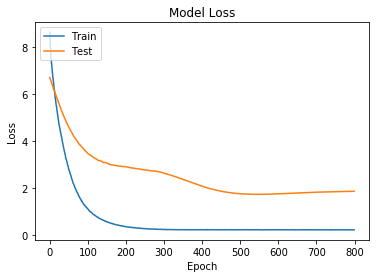

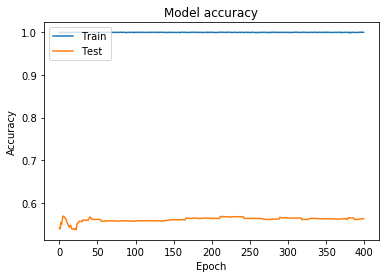

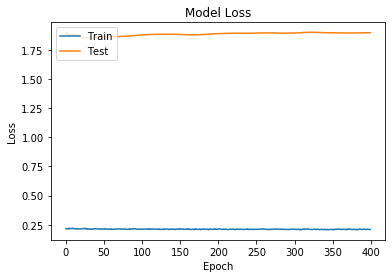

In [40]:
%matplotlib inline
# the first 600 epochs
plot_accuracy(history1)
plot_loss(history1)
# the next 500 epochs
plot_accuracy(history2)
plot_loss(history2)

### Plot confusion matrix

In [41]:
Y_test_pred = DD_Net.predict([X_test_0, X_test_1])

(21, 21)
[[ 3  0 13  0  0  0  0  0  4  0  0  5  0  4  0  0  0  0  0  0  1]
 [ 0 12  0  0  0  0  5  1  0  0  5  0 13  0 24  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  2  0  0  0  0  0  0  0  1  0  0  0 12]
 [ 0  0  0 29  0  0  8  0  0  3  6  0  3  0  1  0  0  0  5  0  0]
 [ 0  0  0  0 60  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  5  0 20  0 10  0  5  0  0  0  0  0  0  0  5  5  0  5  0  5]
 [ 0  0  0  0  0 15 16  0  0  5  0 10  0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  1 34  0  0  1  4  0  0  0 10  5  0  0  0  0]
 [ 4  0  2  0  0  0  0  0 60  0  0  0  0  3  0  0  1  0  0  0 10]
 [ 0  0  0  0  0  0  0  0  0 70  0  0  0  0 10  0  0  0  0  0  0]
 [ 0  5  0  0  0  0  0  5  0  0 25  0  5  1  9  5  5  0  0  0  0]
 [ 0  0  0 22  0  5  5  0  5  0  0  7  0  0  0  0  0  0  5  1  5]
 [ 0  0  0  0  0 11  0  0  0  0  0  0 35  0  4  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 14  0  0  0  0 61  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  0  0  0  0  0 15  0  0  6 45  7  0  0  0  0  0]
 

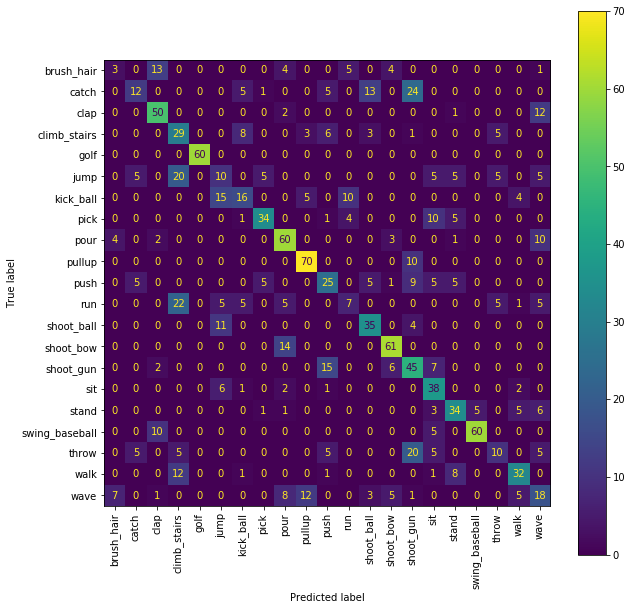

In [42]:
Y_test_pred_cls = np.argmax(Y_test_pred, axis=1)
Y_test_cls = np.argmax(Y_test_input, axis=1)
Y_test_cls[:10], Y_test_pred_cls[:10]

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
normalize= None # 'true'
cm = confusion_matrix(Y_test_cls, Y_test_pred_cls, normalize=normalize, labels=range(len(le.classes_)))
print(cm.shape)
print(cm)
# print(np.sum(np.diagonal(cm)) / np.sum(cm)) # accuracy

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_) #sorted(set(le.inverse_transform(Y_test_cls))))

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation=90, ax=ax)


In [43]:
# other statistics
import pandas as pd

df = pd.DataFrame()

for i, cls_name in enumerate(le.classes_):
    precision = np.round(cm[i, i] / np.sum(cm[:, i]), 2)
    recall = np.round(cm[i, i] / np.sum(cm[i, :]), 2)
    train_size =  list(le.inverse_transform(np.argmax(Y_input, axis=1))).count(cls_name)
    test_size =  list(le.inverse_transform(np.argmax(Y_test_input, axis=1))).count(cls_name)
    df = df.append({
        'class_name': cls_name,
        'precision': precision,
        'recall': recall,
        'train_size': train_size,
        'test_size': test_size
    }, ignore_index=True)

print(df)

        class_name  precision  recall  test_size  train_size
0       brush_hair       0.21    0.10       30.0       105.0
1            catch       0.44    0.20       60.0       170.0
2             clap       0.64    0.77       65.0       145.0
3     climb_stairs       0.33    0.53       55.0       140.0
4             golf       1.00    1.00       60.0       150.0
5             jump       0.21    0.17       60.0       125.0
6        kick_ball       0.43    0.32       50.0       125.0
7             pick       0.74    0.62       55.0       120.0
8             pour       0.62    0.75       80.0       195.0
9           pullup       0.78    0.88       80.0       195.0
10            push       0.42    0.42       60.0       150.0
11             run       0.27    0.13       55.0       140.0
12      shoot_ball       0.59    0.70       50.0       125.0
13       shoot_bow       0.76    0.81       75.0       185.0
14       shoot_gun       0.39    0.60       75.0       195.0
15             sit      

### Eval on doctored test set

In [ ]:
# quick evaluate on doctored test set

X_test_d,Y_test_d = data_generator(Test_doctored,C,le)
X_test_d, Y_test_d =  cleaner.augment_XY(X_test_d, Y_test_d, factor=5)
print(len(X_test_d), Y_test_d.shape)
DD_Net.evaluate(list(ddnet.preprocess_batch(X_test_d, C)), Y_test_d)

# DD_Net.evaluate([X_test_0,X_test_1], Y_test_input)

### Save model to disk

In [ ]:
model_path = 'jhmdb_openpose_model_upper_10.h5'
ddnet.save_DDNet(DD_Net, model_path)

### Examine wrong predictions

In [ ]:
X_test_vis, Y_test_vis = cleaner.augment_XY(X_test, Y_test, factor=1)
print(len(X_test_vis))
X_test_vis_0, X_test_vis_1 = ddnet.preprocess_batch(X_test_vis, C)
Y_test_vis_pred = DD_Net.predict([X_test_vis_0, X_test_vis_1])

def check_labels(Y_true, Y_pred, le, filenames, labels=['wave']):
    assert Y_true.shape[0] == Y_pred.shape[0] == len(filenames)
    for yt, yp, fn in zip(Y_true, Y_pred, filenames):
        cls_true = np.argmax(yt)
        cls_pred = np.argmax(yp)
        if le.inverse_transform([cls_true])[0] in labels:
            correct = (cls_true == cls_pred)
            print(correct, '\t', le.inverse_transform([cls_pred])[0], '\t\t\t', fn)
    
check_labels(Y_test, Y_test_vis_pred, le, Test_undoctored['filename'])

### Refit using Training + Test Data

In [ ]:
print(Y_input.shape, Y_test_input.shape)
X_refit = X_input + X_test_input
Y_refit = np.concatenate([Y_input, Y_test_input])
assert len(X_refit) == Y_refit.shape[0]
print(len(X_refit))
refit_sample_weight = get_sample_weight(Y_refit)

In [ ]:
X_refit_0, X_refit_1 = ddnet.preprocess_batch(X_refit, C)

In [ ]:
# create a new net
refit_net = ddnet.create_DDNet(C)

lr = 1e-3
refit_net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-5)

history1 = refit_net.fit([X_refit_0,X_refit_1],Y_refit,
                    batch_size=len(Y_refit),
                    epochs=800,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    sample_weight=refit_sample_weight
                    )

lr = 1e-4
refit_net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)

history2 = refit_net.fit([X_refit_0,X_refit_1],Y_refit,
                    batch_size=len(Y_refit),
                    epochs=500,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    sample_weight=refit_sample_weight
                    )


In [ ]:
# the first 600 epochs
plot_accuracy(history1)
plot_loss(history1)
# the next 500 epochs
plot_accuracy(history2)
plot_loss(history2)

### Save/Load Model

In [ ]:
with open('jhmdb_le.pkl', 'wb') as f:
    pickle.dump(le, f)
le.classes_.tolist()

In [ ]:
model_path = 'jhmdb_openpose_model_upper_10_refit.h5'
ddnet.save_DDNet(refit_net, model_path)

In [ ]:
# Load the model back from disk
new_net = ddnet.load_DDNet(model_path)
# Evaluate against test set, you should get the same accuracy
new_net.evaluate([X_test_0,X_test_1],Y_test)